In [1]:
import pandas as pd

def seq_id_to_domain_record(seq_id: str) -> tuple: 
    # (pdb, chain, domain) -> id
    try:
        pdb, chain, lower, upper = seq_id.split("_")
        domain = (lower, upper)
    except:
        pdb, chain = seq_id.split("_")
        domain = " "
    return pdb, chain, domain

def get_pred_cys(df_pred: pd.DataFrame):
    pred_cys_residues = set()
    for _, row in df_pred.iterrows():
        seq_id = row['seq_id']
        pdb, chain, domain = seq_id_to_domain_record(seq_id)

        lower = 1 if domain == " " else int(domain[0])
        resi1_domain_seq_num = row['resi_seq_posi_1'] + lower
        resi2_domain_seq_num = row['resi_seq_posi_2'] + lower

        resi1_id = (pdb, chain, resi1_domain_seq_num)
        resi2_id = (pdb, chain, resi2_domain_seq_num)
        if row['resi_1'] == 'C': pred_cys_residues.add(resi1_id)
        if row['resi_2'] == 'C': pred_cys_residues.add(resi2_id)
    return pred_cys_residues

def dissection_pred_cys(
    pred_cys: set,
    anno_cys: set,
    ssbond_cys: set,
) -> dict:
    
    pred_true = pred_cys & anno_cys
    false_ssbond = pred_cys & ssbond_cys
    others = pred_cys - pred_true - false_ssbond
    
    total = pred_true | false_ssbond | others
    
    return {
        "true positive": len(pred_true) / len(total),
        "disulfide bond": len(false_ssbond) / len(total),
        "other reasons": len(others) / len(total)
    }
    

In [2]:
df_anno = pd.read_table(f"{PROJECT_DIR}/dataset/transform/test_metalnet.tsv")
true_cys_residues = set()
for _, row in df_anno.iterrows():
    if row['resi'] == 'C':
        true_cys_residues.add((row['pdb'], row['metal_chain'], row['resi_ndb_seq_can_num']))

df_ssbond = pd.read_table("./test_disulfide_pairs.tsv")
ssbond_residues = set()
for _, row in df_ssbond.iterrows():
    ssbond_residues.add((row['pdb'], row['chain'], row['resi_ndb_can_seq_num_1']))
    ssbond_residues.add((row['pdb'], row['chain'], row['resi_ndb_can_seq_num_2']))

In [3]:
df_pred_new = pd.read_table(f"../../pred_pairs.tsv")
df_pred_new = df_pred_new[df_pred_new['filter_by_graph'] == 1]
df_pred_old = pd.read_table(f"../../pred_pairs_old_model.csv")
df_pred_old = df_pred_old[df_pred_old['pred'] == 1]

In [4]:
perf = dissection_pred_cys(get_pred_cys(df_pred_new), anno_cys=true_cys_residues, ssbond_cys=ssbond_residues)
old_perf = dissection_pred_cys(get_pred_cys(df_pred_old), anno_cys=true_cys_residues, ssbond_cys=ssbond_residues)

In [5]:
keys = list(perf.keys())

Text(0, 0.5, 'Fraction')

Text(0.5, 0, 'Composition of predicted cysteine')

([<matplotlib.axis.XTick at 0x7fa7d20cc220>,
 [Text(0, 0, 'true positive'),
  Text(1, 0, 'disulfide bond'),
  Text(2, 0, 'other reasons')])

Text(1, -0.1, '')

Text(0.675, -0.12, 'false positive')

(0.0, 1.0)

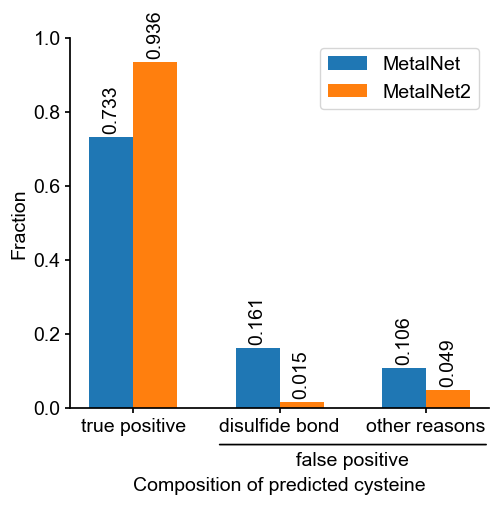

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(f"{PROJECT_DIR}/asset/metalnet.mplstyle")

fig, ax = plt.subplots(figsize=(5.4, 4.8))
plt.ylabel("Fraction")
plt.xlabel("Composition of predicted cysteine", labelpad=30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
coor_x = np.arange(len(keys))
width = 0.3
rects_old = plt.bar(coor_x - width / 2, [old_perf[k] for k in keys], width=width)
for rect in rects_old:
    height = rect.get_height()
    text = plt.text(rect.get_x() + rect.get_width() / 2, height + 0.02, "{:.3f}".format(height), ha="center", rotation=90.)
rects_new = plt.bar(coor_x + width / 2, [perf[k] for k in keys], width=width)
for rect in rects_new:
    height = rect.get_height()
    text = plt.text(rect.get_x() + rect.get_width() / 2, height + 0.02, "{:.3f}".format(height), ha="center", rotation=90.)

plt.xticks(coor_x, labels=keys)

# 使用annotate绘制横线和文本
ax.annotate('', xy=(0.35, -0.1), xycoords='axes fraction', xytext=(1, -0.1), 
            textcoords='axes fraction', arrowprops=dict(arrowstyle="-", lw=1.25))

# 在横线下方添加文本
ax.text(0.675, -0.12, 'false positive', transform=ax.transAxes, ha='center', va='top')


plt.ylim(bottom=0, top=1)
plt.legend(labels=['MetalNet',
                   'MetalNet2'],
           loc='upper right',
           bbox_to_anchor=(1, 1))
plt.savefig("./fig/comparasion_cys_pred_new_old.pdf", bbox_inches="tight", transparent=True)